# A Bayesian mixed effects Support Vector Machine for learning and predicting daily substance use disorder patterns

This notebook takes daily substance use logs and learns patterns of alcohol use. Features include:
* Standard summaries and graphics of drinking data (e.g., 7-day, 30-day frequencies)
* Handles both fixed and random effects in a flexible Bayesian mixed effects SVM (we call it Mixed.SVM)
* Provides classification for the variable of interest (heavy drinking in this example).  
* Provides effect estimates and 95% credible intervals (unlike standard SVMs).
* Inference can be drawn using the credible intervals (is the variable associated with heavy drinking days?).
* Estimates individual-level risk patterns.

## Dataset
<span style="color:red">IMPORTANT: THIS NOTEBOOK APPLIES THE TOOLKIT TO SIMULATED DATA!
</span> 

To illustrate the use of the Bayesian mixed effects SVM we simulated data for a cohort of heavy drinkers. You may run the entire notebook on this simulated data

First we read in the simulated daily log data. This tracks if the individual used alcohol, nicotine, cannabis, or other drugs.


***

In [4]:
rm(list=ls()) # cleans memory

# !!! Change the next two lines to the location of example.RData.

setwd('/home/path-to-project-folder/') # change path to directory below your Mixed.SVM folder

load('Mixed.SVM/data/processed/example.RData') # loads simulated daily log

In [5]:
head(drinks)

ursi,male,age,Day,SD,AD,HD,MD,NICUSEDAY,THCUSEDAY,OTHERDRUGUSE
1,1,40,1,7.0507639,1,1,0,1,1,0
1,1,40,2,0.0000000,0,0,0,0,0,0
1,1,40,3,0.0000000,0,0,0,0,0,0
1,1,40,4,0.5401274,1,0,0,0,0,0
1,1,40,5,0.6186828,1,0,0,0,1,0
1,1,40,6,3.2584603,1,0,1,0,1,0


Above we loaded the daily drinking and drug use data:


| Variable | Description | Coding |
| :--------| :--------- |   ------|
| ursi | Individual ID |        |
| male | Male | 1=male;2=female | 
| age | Age in years | 
| Day | Day | |
| SD | Standard drinks consumed | 
| AD | Did drinking take place? | 1=yes;0=no |
| HD | Did heavy drinking take place? | 1=yes;0=no |
| MD | Did moderate drinking take place? | 1=yes;0=no |
| NICUSEDAY | Any nicotine use (cigarettes, e-cigs, smokekess, etc) | 1=yes;0=no |
| THCUSEDAY | Any use of THC | 1=yes;0=no |
| OTHERDRUGUSE | Any use of any other drugs | 1=yes;0=no |



We want to learn the alcohol drinking patterns in this data. In other words, we want to fit a model of heavy drinking (`HD`) considering demographics (`age`, `male`) and additional variables that may change over time and influence risk of heavy drinking, including other substances (nicotine, cannabis, and other drugs; `NICUSEDAY`, `THCUSEDAY`, and `OTHERDRUGUSE`, respectively). 


***


## Model

The Mixed.SVM is described in detail in the manuscript. 

The analysis requires several R libraries. We'll go ahead and install and load these now.

In [6]:
packages <- c("statmod", "mvtnorm",
             "Matrix", "splines","xtable","IRdisplay","repr","plotly",
              "extrafont","ggplot2","gridExtra","grid","table1")

## Now load or install and load 
package.check <- lapply(
  packages,
  FUN = function(x) {
    if (!require(x, character.only = TRUE)) {
      install.packages(x, dependencies = TRUE)
      library(x, character.only = TRUE)
    }
  }
)

# set up for plotting figures
options(bitmapType="cairo") #linux

#options(bitmapType="quartz") # mac


set.seed(2) #sets a seed for random number generators used by the algorithm



Loading required package: statmod
Loading required package: mvtnorm
Loading required package: Matrix
Loading required package: splines
Loading required package: xtable
Loading required package: IRdisplay

Attaching package: ‘IRdisplay’

The following object is masked from ‘package:xtable’:

    display

Loading required package: repr
Loading required package: plotly
Loading required package: ggplot2

Attaching package: ‘plotly’

The following object is masked from ‘package:ggplot2’:

    last_plot

The following object is masked from ‘package:stats’:

    filter

The following object is masked from ‘package:graphics’:

    layout

Loading required package: extrafont
Registering fonts with R
Loading required package: gridExtra
Loading required package: grid
Loading required package: table1

Attaching package: ‘table1’

The following objects are masked from ‘package:xtable’:

    label, label<-

The following objects are masked from ‘package:base’:

    units, units<-



Next we source the algorithm code as well as tools to help summarize the results.

In [7]:
source('Mixed.SVM/src/R/mixed-svm.R')

The arguments of Mixed.SVM are the following

| Argument | Description | Setting |
| -------- | ----------- | --------- | 
| Y | Response vector encoded 0 and 1 | `HD` |
| X | Design matrix corresponding to Y | `male`, `age`, `NICUSEDAY`, `THCUSEDAY`, `OTHERDRUGUSE` |
| T | Vector of times at which the observations in Y were taken | `Day` |
| U | Vector which indentifies the user IDs for the observations in `Y`, `X`, and `T` | `ursi` |
| Tmax | Maximum time to be included in the analysis | 720 |
| knot.seq | Interior knot set for subject specific trajectories | 0.5 | 
| Iter | Number of MCMC iterations | 100000 |
| burn.in | Number of MCMC iterations to discard | 50000

We set these parameters for modeling:

In [8]:
Y <- as.vector(drinks$HD) # outcome
X <- as.matrix(drinks[,c("male","age","NICUSEDAY","THCUSEDAY","OTHERDRUGUSE")]) # covariates
T <- as.vector(drinks$Day) # times
U <- as.vector(drinks$ursi) # individual id
Tmax <- 720
knot.seq <- c(0.5)
Iter <- 100000
burn.in <- 50000

Next we call the Mixed.SVM algorithm. 

In [9]:
# Runs the algorithm
# Remove # to run
#MCMC.res <- Mixed.SVM(Y, X, T, U, Tmax, knot.seq, Iter)

# Saves the results
# Remove # to run
# save(MCMC.res,file='Mixed.SVM/reports/demo-results.RData')

# Here we pull up previously saved results
load(file='Mixed.SVM/reports/demo-results.RData')

***

## Results


### Daily drinking summaries

First we summarize daily drinking for the simulated input dataset:

| Variable | Description |
| -------- | ----------- |
| pdd | proportion drinking days |
| phdd | proportion heavy drinking days |
| ddd | average standard drinks per drinking day |
| dpd | average standard drinks per day |
| totaldays | total days |
| totaldrinkdays | total number of drinking days |
| totalheavydays | total number of heavy drinking days | 
| phwd | proportion heavy drinking days while drinking | 
| mxd | maximum standard drinks|

At the baseline assessment in this study, the participants are interviewed and a detailed log of daily drinking is created for the previous 3 months (90 days). So we start summarizing drinking on day 90. Day 181 corresponds to three month after baseline, day 364 for the nine month visit, and day 637 for the eighteen month visit. For these four visits, we'll summarize these variables for the previous month (30 days).

These are easily adjustable for your study, see `time` and `visitdays` below. The `log.summaries` function generates individual level summaries for the the variables described above. `includevisitday` indicates if the visit day should be included in the summary or not.

In [10]:
iid <- unique(drinks$ursi) # individual id's found in the dataset

time <- 30 # summarize for one month before the visit
visitdays <- c(90,181,364,637) # visit days: baseline, 3-months, 9-months, 18-months

# summarize previous week at baseline, 3-,9-,and 12-months
base <- log.summaries(iid, timeframe=time,visitday=visitdays[1],includevisitday=FALSE)
mo3 <- log.summaries(iid, timeframe=time,visitday=visitdays[2],includevisitday=FALSE)
mo9 <- log.summaries(iid, timeframe=time,visitday=visitdays[3],includevisitday=FALSE)
mo18 <- log.summaries(iid, timeframe=time,visitday=visitdays[4],includevisitday=FALSE)


We summarize drinking over the participants in the study by computing the mean, standard deviation, median, minimum, maximum, and number of missing observations for one month of drinking logs at baseline, 3 month, 9 months, and 18 months.

In [11]:
base$visit <- "Baseline"
mo3$visit <- "3 Months"
mo9$visit <- "9 Months"
mo18$visit <- "18 Months"

allmo <- rbind(base,mo3,mo9,mo18)
allmo$visit <- factor(allmo$visit,levels=c("Baseline","3 Months", "9 Months", "18 Months"))


In [12]:
label(allmo$pdd) <- "<b>Proportion drinking days"
label(allmo$phdd) <- "<b>Proportion heavy drinking days"
label(allmo$ddd) <- "<b>Average standard drinks per drinking day"
label(allmo$dpd) <- "<b>Average standard drinks per day"
label(allmo$totaldays) <- "<b>Total days"
label(allmo$totaldrinks) <- "<b>Total drinks"
label(allmo$totaldrinkdays) <- "<b>Total number of drinking days"
label(allmo$totalheavydays) <- "<b>Total number of heavy drinking days" 
label(allmo$phwd) <- "<b>Proportion heavy drinking days while drinking"
label(allmo$mxd) <- "<b>Maximum standard drinks"

display_html(table1(~pdd + phdd + ddd + dpd + totaldrinks + totaldays + totaldrinkdays + 
                    totalheavydays + phwd + mxd | visit, data=allmo,caption="30-Day Drinking Summaries in Simulated Data", overall=NULL))

,Baseline(N=190),3 Months(N=190),9 Months(N=190),18 Months(N=190)
Proportion drinking days,,,,
Mean (SD),0.623 (0.0890),0.632 (0.0906),0.634 (0.0880),0.630 (0.0896)
"Median [Min, Max]","0.633 [0.367, 0.800]","0.633 [0.400, 0.867]","0.633 [0.367, 0.833]","0.633 [0.367, 0.833]"
Proportion heavy drinking days,,,,
Mean (SD),0.258 (0.0839),0.261 (0.0798),0.268 (0.0748),0.256 (0.0806)
"Median [Min, Max]","0.267 [0.0667, 0.467]","0.267 [0.0333, 0.500]","0.267 [0.100, 0.467]","0.267 [0.0333, 0.500]"
Average standard drinks per drinking day,,,,
Mean (SD),4.51 (0.670),4.61 (0.666),4.63 (0.630),4.48 (0.669)
"Median [Min, Max]","4.50 [2.64, 6.31]","4.63 [2.77, 6.22]","4.57 [3.16, 6.56]","4.47 [2.41, 6.45]"
Average standard drinks per day,,,,


Let's take a look at the individual trends in heavy drinking over the duration of the simulated study. 

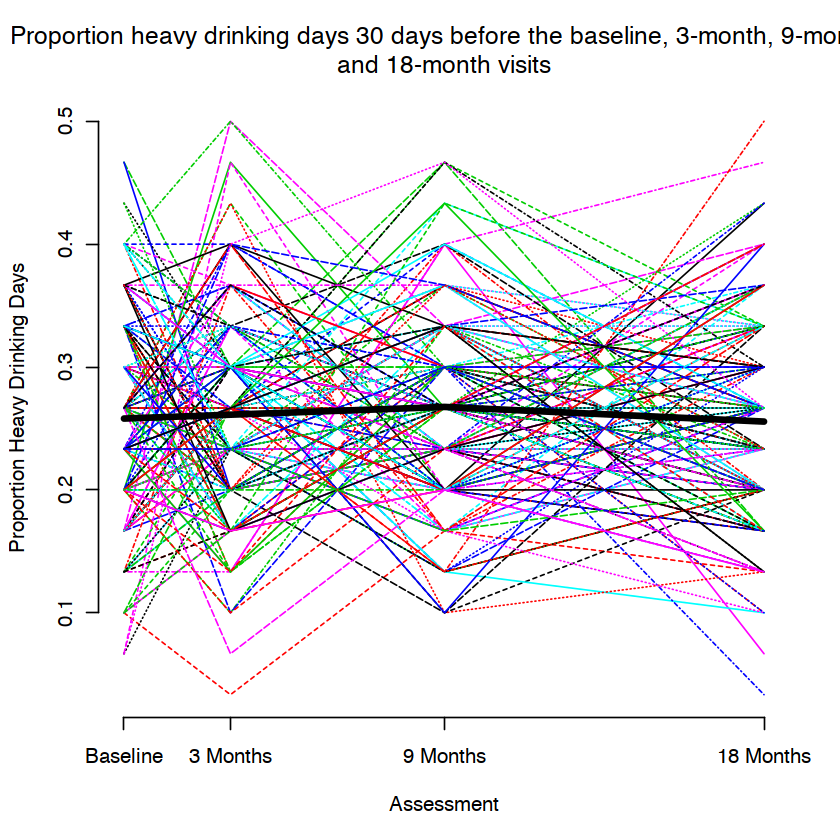

In [13]:
# put together the summaries of heavy drinking days in the past month at the four assessments
trend <- cbind(base=base$phdd,mo3=mo3$phdd,mo9=mo9$phdd,mo18=mo18$phdd)
h <- t(trend) # transpose for plotting
ave <- rowMeans(h,na.rm=TRUE) # average values across individuals
matplot(visitdays, h, type='l', xlab="Assessment", axes=FALSE, ylab='Proportion Heavy Drinking Days',main="Proportion heavy drinking days 30 days before the baseline, 3-month, 9-month,
and 18-month visits") # plot the trend over the study
axis(2)
axis(side=1,at=visitdays,labels=c("Baseline","3 Months","9 Months","18 Months"))
matlines(visitdays,ave,lwd=4,col="black") # plot the average

The individuals in this study on average drank heavily 25-30% of the past 30 days before each assessment. However, each individual has their own drinking pattern that typical summaries would not capture. 

### Mixed-SVM results
The `Mixed.SVM` algorithm can take some time to run 100K iterations. We have loaded the results of a previous run so we can look at the results.

#### Classification Rate

In [15]:
mean(1-(MCMC.res$Misclassified[burn.in:Iter]/2)/nrow(drinks))

[1] 0.8958765

For the simulated data, the model classifies 90% of heavy drinking days correctly. 

##### Performance Metrics

In [17]:
confusionmatrix <- Pred.summary.MSVM(MCMC.res,Y, X, T, U, Tmax, knot.seq=c(.5), Iter, burn.in=50000)

Here we compute a summary of the performance of the Mixed-SVM algorithm in predicting heavy drinking days. This includes the rate of true positives (TP or sensitivity), false positives (FP), true negatives (TN or specificity), and false negatives (FN).

In [19]:
print(confusionmatrix)

$TP
[1] 0.6956982

$FP
[1] 0.03300538

$TN
[1] 0.9669946

$FN
[1] 0.3043018



In this simulated data, the model predicts 70% of the days with heavy drinking and 97% of days without heavy drinking correctly. The false positive rate is 3% and the false negative rate is 30%.

#### Parameter Summary

In [20]:
# Regression parameter summary
names <- c("male","age","NICUSEDAY","THCUSEDAY","OTHERDRUGUSE")

summary <- Reg.summary(MCMC.res,burn.in,names)
summary 

Variable,Point Est.,Lower:CI95,Upper:CI95,
male,-0.2357,-0.2476,-0.2235,significant
age,-0.0196,-0.0201,-0.019,significant
NICUSEDAY,2.0704,2.0642,2.0768,significant
THCUSEDAY,-8e-04,-0.0041,0.0023,not
OTHERDRUGUSE,2.0229,2.0088,2.0378,significant


Overall among heavy drinkers in this simulation, we find that age (younger), gender (female), and using nicotine and other drugs are associated with increase risk of heavy drinking episodes. A variable is statistically significant when the 95% credible intervals do not contain zero. 

#### Report of subject specific heavy drinking risk

Next we look at the estimated risk trajectories for each study participant. Since there are many trajectories and the user may want to quickly examine the entire cohort, we include some code to layout the graphs 6 per page. For space, we only display the graphs for the first 18 participants.

Each graph is labeled with the de-identified participant id. The risk of heavy drinking is charted by days that individual is followed in the study up to `Tmax`. Values above zero indicate increased risk of heavy drinking and values below zero indicate decreased risk of heavy drinking. The influence of using or discontinuing use of other substances (e.g, tobacco) can be seen by jumps in risk.

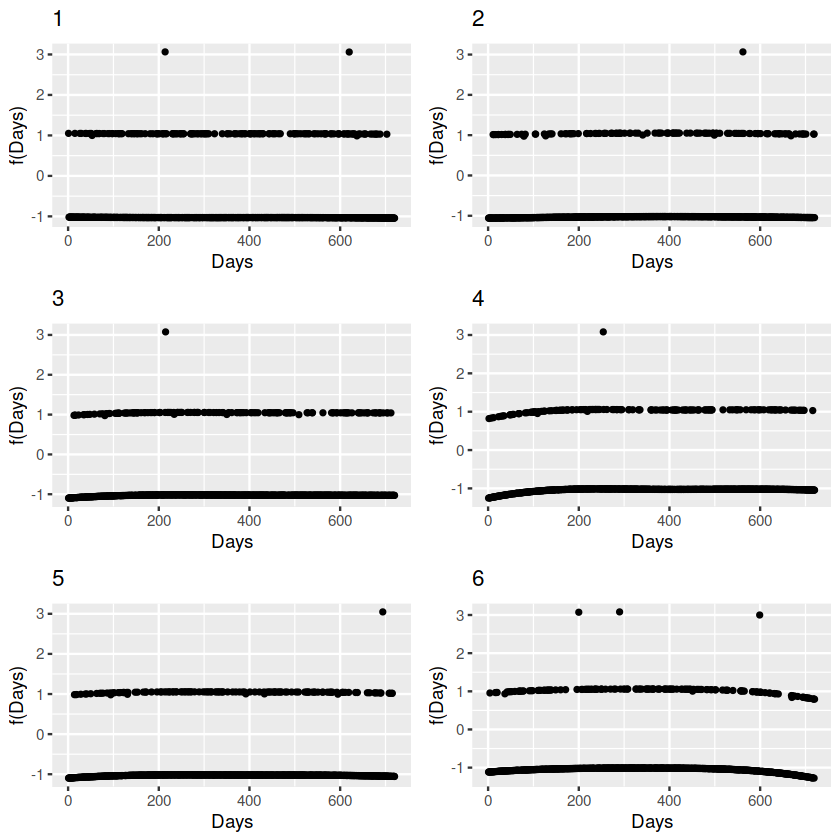

In [14]:
# prints 6 estimated trajectories per page
subjects<-unique(U)

vplayout <- function(x, y) viewport(layout.pos.row = x, layout.pos.col = y)

pages <- 1   # How many pages of output, 6 plots to a page
for (i in 1:pages) {
        grid.newpage()
        pushViewport(viewport(layout = grid.layout(3, 2)))
    for (j in 1:6) {
        index <- i*j
        # function that summaries the results from the SVM.Mixed into a plot for an individual
        fig1 <- Ind.trajectory(subj=subjects[index], X, T, U, MCMC.res, burn.in, knot.seq, Tmax)
        if ((j %% 2) == 0) {
            print(fig1, vp = vplayout(j/2, 2))
        } else {
            print(fig1, vp = vplayout(ceiling(j/2), 1))
        }
   } 
}


#### Analysis of specific subject drinking trajectories

The user may look closely at an individual's estimated risk of heavy drinking trajectory over time. The function `Ind.trajectory.pretty` takes in the subject indentifier and the results of `SVM.Mixed` and presents the estimated heavy drinking trajectories for two individuals in the simulated data (subject `18` and `24`). Each point is the value of the linear predictor for that given day. The further the values are away from zero, the more or less likely at individualis going to have a heavy drinking day. These values are color coded by the 8 combinations of the 3 time varying covariates (nicotine, cannabis (THC), and other drug use).

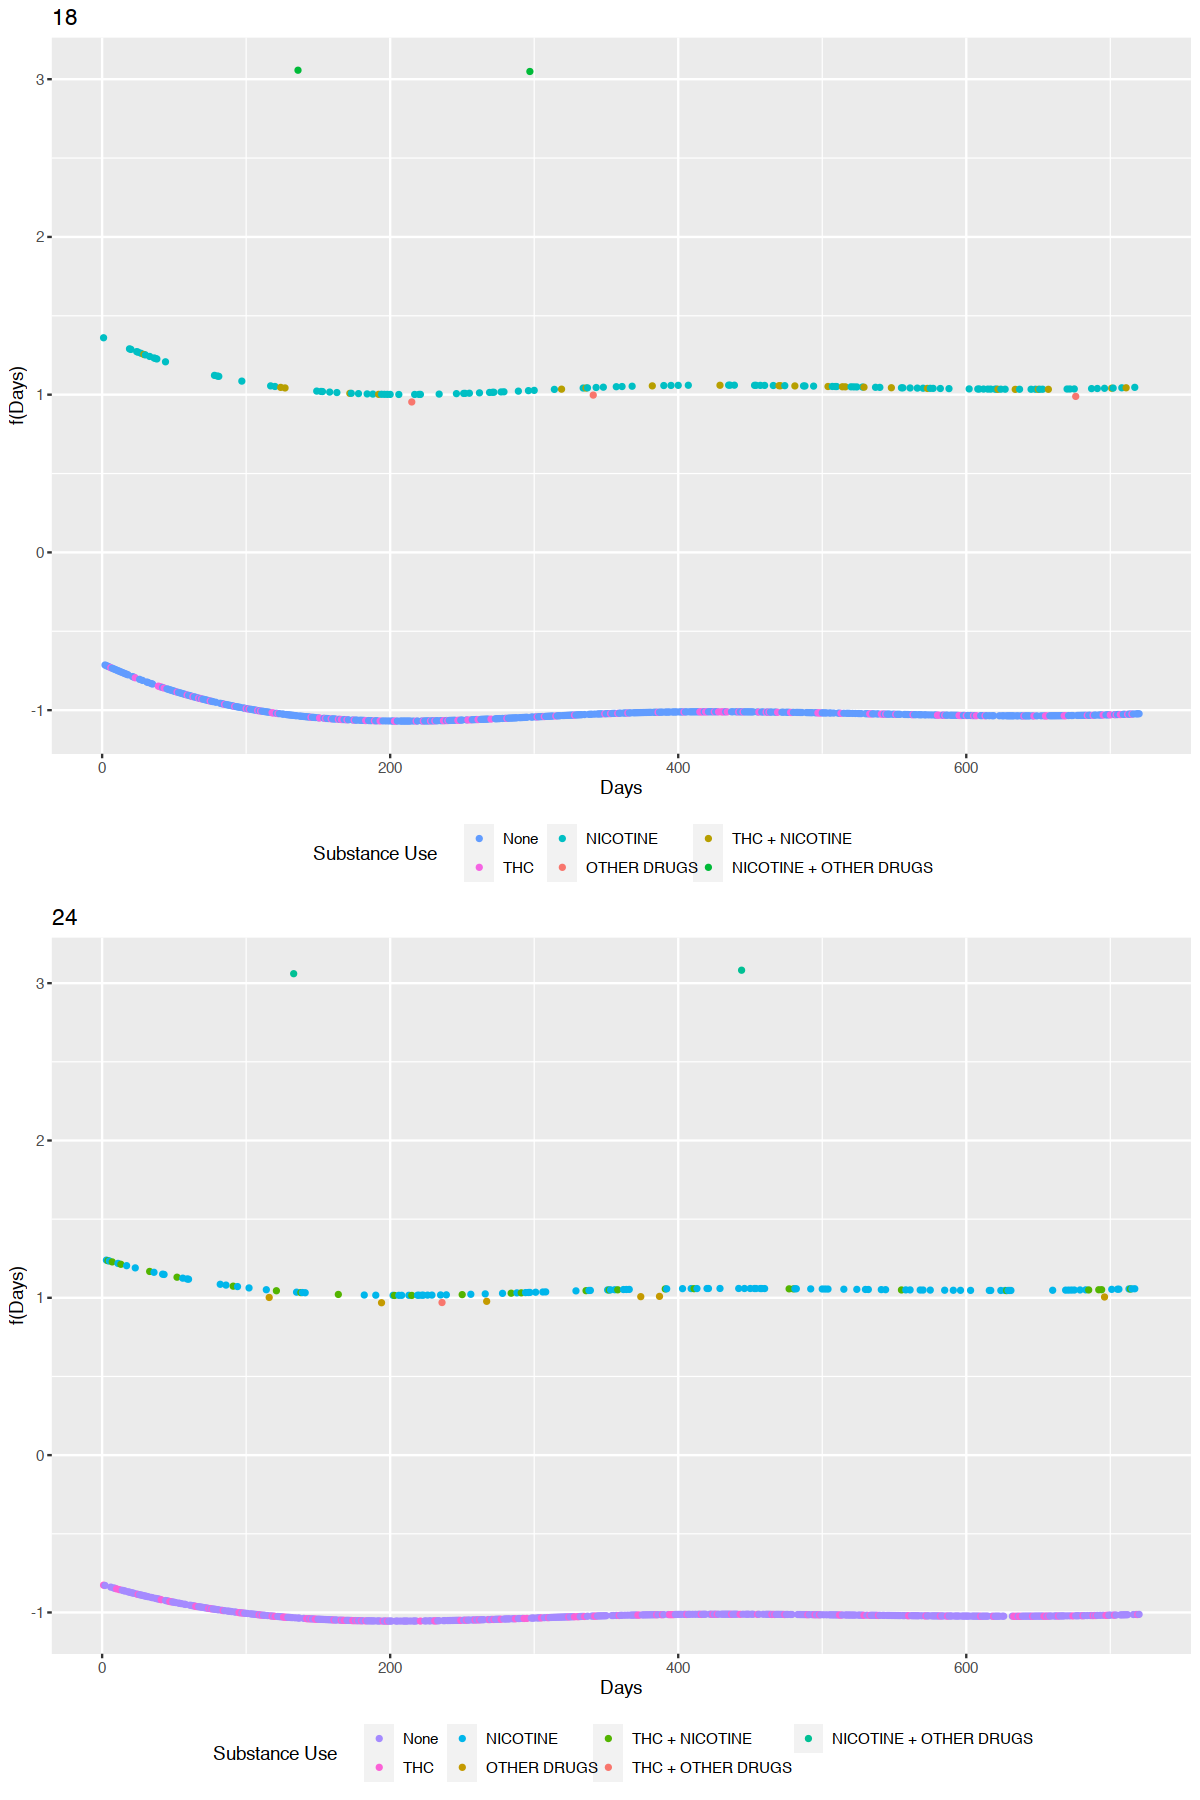

In [21]:
subjects<-unique(U)

subj <- c(18,24)
options(repr.plot.width=10, repr.plot.height=15)

vplayout <- function(x, y) viewport(layout.pos.row = x, layout.pos.col = y)

grid.newpage()
pushViewport(viewport(layout = grid.layout(length(subj), 1)))

for (j in 1:length(subj)) {
    fig1 <- Ind.trajectory.pretty(subj=subj[j], X, T, U, MCMC.res, burn.in, knot.seq, Tmax)
    print(fig1,vp=vplayout(j,1))
} 

#### Significance of the individual specific random trajectories
We now look at the individual random trajectories and corresponding 95% credible bands for subject `18`. If the bands exclude zero, the random effects are significant for that individual.

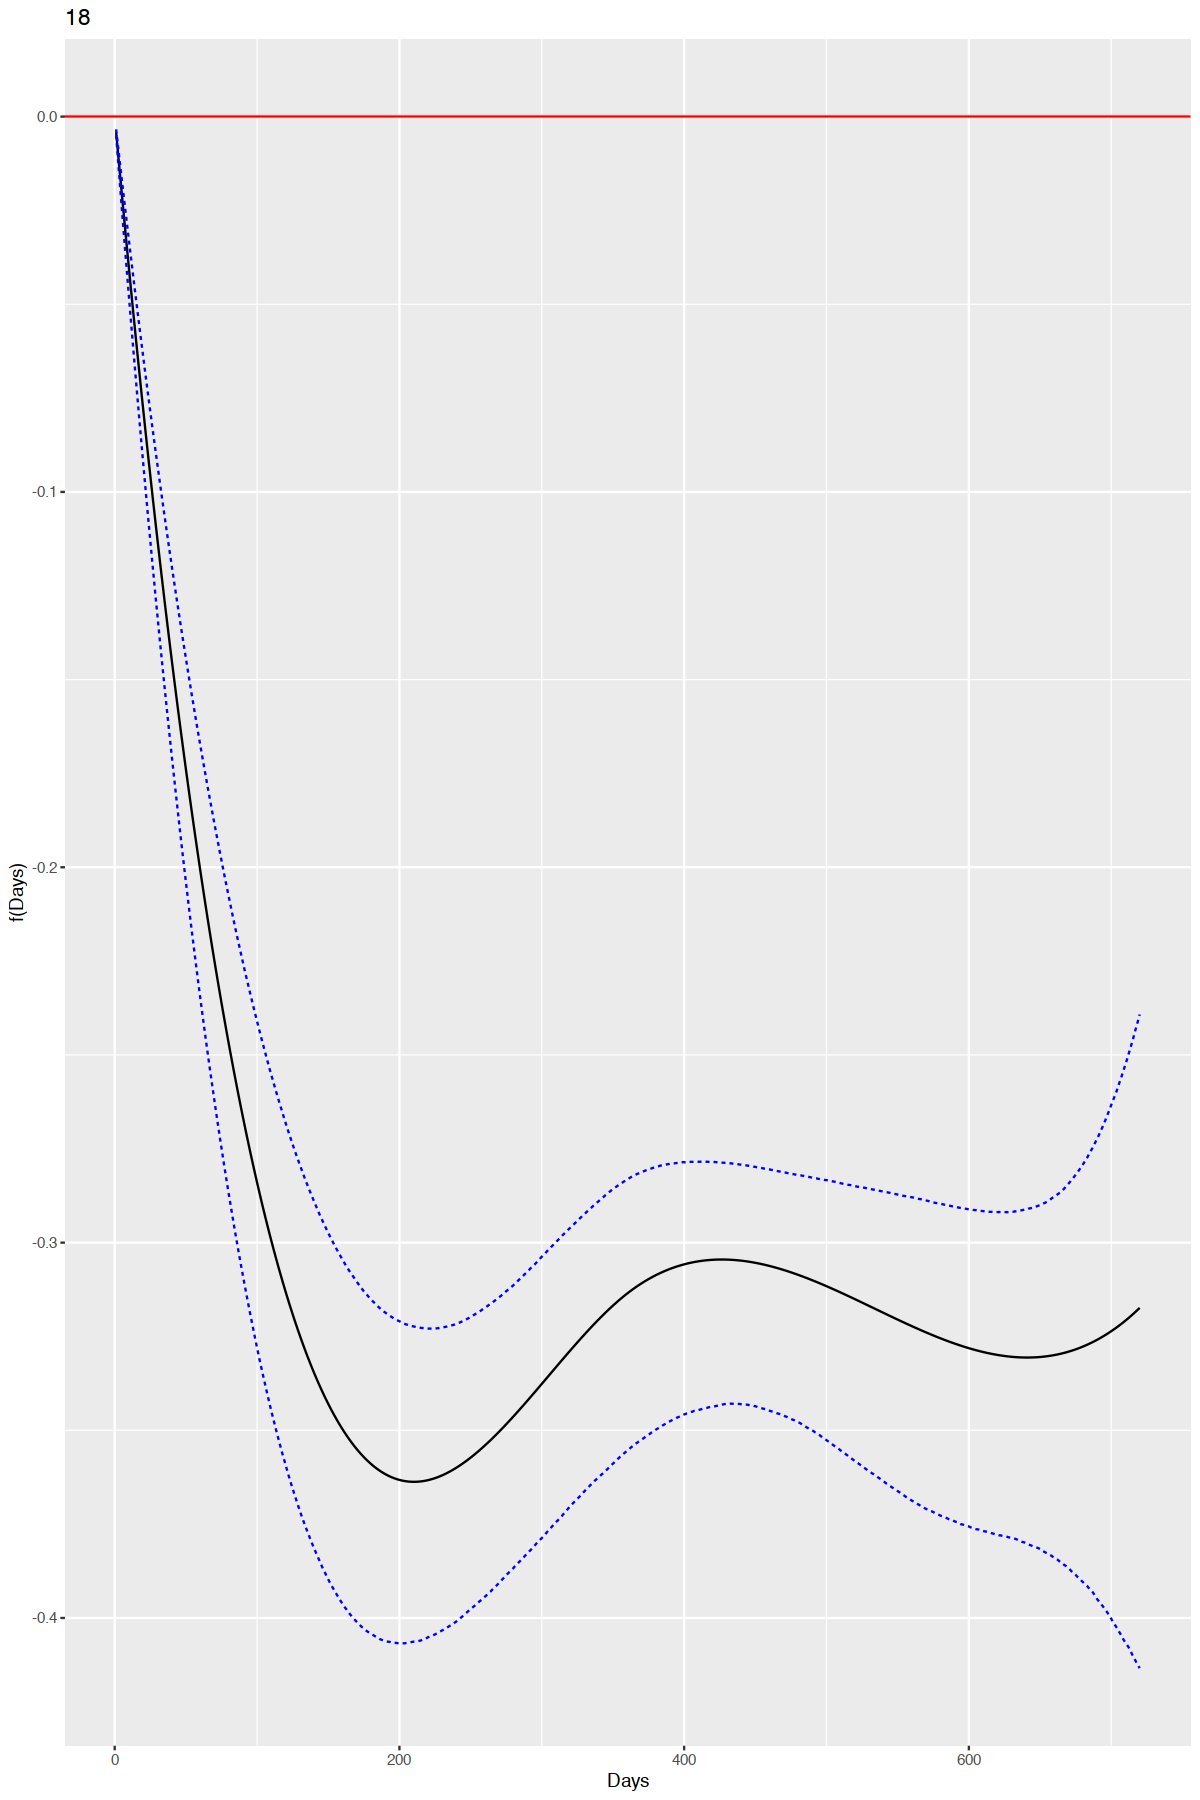

In [23]:
subjects<-unique(U)

subj <- c(18) # specify which subjects to plot

options(repr.plot.width=10, repr.plot.height=15)

vplayout <- function(x, y) viewport(layout.pos.row = x, layout.pos.col = y)

grid.newpage()
pushViewport(viewport(layout = grid.layout(length(subj), 1)))

for (j in 1:length(subj)) {
    fig1 <- Ind.trajectory.CI(subj=subj[j], T, U, MCMC.res, burn.in, knot.seq, Tmax)
    print(fig1,vp=vplayout(j,1))
} 
